# Density charge and density spin evolution over time

Author: Javier Norambuena Leiva — Posted: . Last updated: .

Here we discuss how to calculate the spin and charge density of the ground state of a molecule. This state is evolved over time to see how this density change over it.

In [2]:
from pennylane import numpy as np
import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
import matplotlib.pyplot as plt

## Hamiltonian build

Here we use the construction of the hamiltonian of $H^{2}$ that it indicated in the [Building Hamiltonian Demo](https://pennylane.ai/qml/demos/tutorial_quantum_chemistry.html).

## Optimization structure and ground state calculation

The idea is the evolution of the ground state, so, the first thing is find it. We know that the VQE construct the state inside the circuit so, we just need to find the minimun energy value and with the parameters, we will be able to reconstruct the state inside the circuit. Here we use the gradient minimization method used in [A brief overview of VQE](https://pennylane.ai/qml/demos/tutorial_vqe.html) with the same values, because its the same molecule.

In [53]:
symbols = ["H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True)

electrons = 2 #Half filling
_, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=1)

hf = qml.qchem.hf_state(electrons, qubits)
singles, doubles = qml.qchem.excitations(electrons, qubits)

In [54]:
def circuit_op(param, wires, obs):
    qml.BasisState(hf, wires=wires)
    for _, term in enumerate(singles):
        qml.SingleExcitation(param[0], wires=term)

    for _, term in enumerate(doubles):
        qml.DoubleExcitation(param[1], wires=term)
    qml.expval( obs )

def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0]

dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev, interface="autograd")
def circuit_op(param, wires, obs):
    qml.BasisState(hf, wires=wires)
    for _, term in enumerate(singles):
        qml.SingleExcitation(param[0], wires=term)

    for _, term in enumerate(doubles):
        qml.DoubleExcitation(param[1], wires=term)
    return qml.expval( obs )

def cost_fn(params, x):
    hamiltonian = H(x)
    return circuit_op(params, wires=range(qubits), obs=hamiltonian)

In [55]:
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient


def grad_x(params, x):
    grad_h = finite_diff(H, x)
    grad = [circuit_op(params, wires=range(qubits), obs=obs) for obs in grad_h]
    return np.array(grad)

In [56]:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

theta = np.array([0.0, 0.0], requires_grad=True)

In [57]:
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(100):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost_fn, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost_fn, theta, x, grad_fn=grad_x)

    energy.append(cost_fn(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

Step = 0,  E = -1.26211784 Ha,  bond length = 0.97232 A
Step = 4,  E = -1.26225065 Ha,  bond length = 0.97777 A
Step = 8,  E = -1.26225139 Ha,  bond length = 0.97861 A
Step = 12,  E = -1.26225140 Ha,  bond length = 0.97875 A

Final value of the ground-state energy = -1.26225140 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    0.0168   0.0478   0.0000
  H    0.9865   1.6228   0.0000
  H    1.8657   -0.0046   0.0000


## Time evolution of the ground state

With the paramaters that will help us to construct the ground state, the next step is introduce the time evolution operator in the circuit. 

Here we use the [qml.ApproxTimeEvolution](https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html#pennylane.ApproxTimeEvolution) module of pennylane, that implement the time evolution operator for any hamiltonian that can be expressed as a product of Pauli matrices.



In [60]:
optimun_x = x
optimun_theta = theta
Hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, optimun_x, charge=1)

@qml.qnode(dev, interface="autograd")
def circuit_time(param, obs, time):
    qml.BasisState(hf, wires=range(qubits))
    for _, term in enumerate(singles):
        qml.SingleExcitation(param[0], wires=term)

    for _, term in enumerate(doubles):
        qml.DoubleExcitation(param[1], wires=term)
    ApproxTimeEvolution(Hamiltonian, time, 3)
    return qml.probs(wires=obs)


## Densities calculation
At this point we have all the requirement elements, the time evolution and the ground state. So, the next thing to see is how to calculate the density with the proyections.

In reference 1, they define the density of each site in a hubbard model as $\rho^{\pm} = \langle n_{i,\uparrow} \rangle \pm \langle n_{i,\downarrow} \rangle$, where the terms are the particle number operator in each site for each type of spin orientation. The important thing is this operator have a expresion in the spin space as $n_{i} = |1\rangle \langle 1|_i$.

If we divide the array the qubits into a block of two consecutive qubits, we can consider each pair as site that can be ocupate by a electron of spin up and one of spin down. 

Let take an example, let say that we have one site and we have two qubits, one to represent the electron with spin up ($Q1$) and another for the spin down ($Q2$), if we want to compute $\langle n_{i,\uparrow} \rangle$ we need to measure $Q1$ (because, is the qubit that represent that configuration of index).

In the following code, we compute the density in each time step to how evolve in time with a time step of $0.2$.

In [62]:
number_pairs = int( qubits/2 )
charge_density = []
spin_density = []
delta_time = 0.2
time_steps = 100
for t in range(time_steps):
    if t%20==0: print(t)
    aux_charge = []
    aux_spin = []
    for i in range(number_pairs):
        result_down = circuit_time(optimun_theta, obs =[2*i], time=t*delta_time)
        result_up = circuit_time(optimun_theta, obs =[2*i+1], time=t*delta_time)
        aux_charge.append(result_up[1] + result_down[1])
        aux_spin.append(result_up[1] - result_down[1])
    charge_density.append( aux_charge )
    spin_density.append( aux_spin )

0
10
20
30
40
50
60
70
80
90


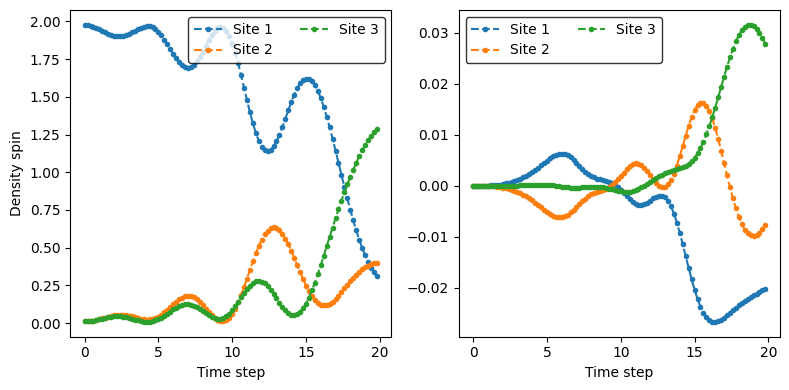

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
for i in range(number_pairs):
    ax[0].plot([i*delta_time for i in range(time_steps)], [j[i] for j in charge_density], ".", label="Site "+str(i+1), ls="dashed")
    ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k',ncol=2)

    ax[1].plot([i*delta_time for i in range(time_steps)], [j[i] for j in spin_density], ".", label="Site "+str(i+1), ls="dashed")
    ax[1].legend(loc="upper left", fontsize='medium',frameon=True, edgecolor='k',ncol=2)

ax[0].set_xlabel('Time step', fontsize=10)
ax[1].set_xlabel('Time step', fontsize=10)

ax[0].set_ylabel('Density charge', fontsize=10)
ax[0].set_ylabel('Density spin', fontsize=10)
#ax[1].get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

## References
1. Frank Arute, Kunal Arya, Ryan Babbush, Dave Bacon, Joseph C. Bardin, Rami Barends, Andreas Bengtsson, Sergio Boixo, Michael Broughton, Bob B. Buckley, David A. Buell, Brian Burkett, Nicholas Bushnell, Yu Chen, Zĳun Chen, Yu-An Chen, Ben Chiaro, Roberto Collins, Stephen J. Cotton, William Courtney, Sean Demura, Alan Derk, Andrew Dunsworth, Daniel Eppens, Thomas Eckl, Catherine Erickson, Edward Farhi, Austin Fowler, Brooks Foxen, Craig Gidney, Marissa Giustina, Rob Graff, Jonathan A. Gross, Steve Habegger, Matthew P. Harrigan, Alan Ho, Sabrina Hong, Trent Huang, William Huggins, Lev B. Ioffe, Sergei V. Isakov, Evan Jeffrey, Zhang Jiang, Cody Jones, Dvir Kafri, Kostyantyn Kechedzhi, Julian Kelly, Seon Kim, Paul V. Klimov, Alexander N. Korotkov, Fedor Kostritsa, David Landhuis, Pavel Laptev, Mike Lindmark, Erik Lucero, Michael Marthaler, Orion Martin, John M. Martinis, Anika Marusczyk, Sam McArdle, Jarrod R. McClean, Trevor McCourt, Matt McEwen, Anthony Megrant, Carlos Mejuto-Zaera, Xiao Mi, Masoud Mohseni, Wojciech Mruczkiewicz, Josh Mutus, Ofer Naaman, Matthew Neeley, Charles Neill, Hartmut Neven, Michael Newman, Murphy Yuezhen Niu, Thomas E. O'Brien, Eric Ostby, Bálint Pató, Andre Petukhov, Harald Putterman, Chris Quintana, Jan-Michael Reiner, Pedram Roushan, Nicholas C. Rubin, Daniel Sank, Kevin J. Satzinger, Vadim Smelyanskiy, Doug Strain, Kevin J. Sung, Peter Schmitteckert, Marco Szalay, Norm M. Tubman, Amit Vainsencher, Theodore White, Nicolas Vogt, Z. Jamie Yao, Ping Yeh, Adam Zalcman, & Sebastian Zanker. (2020). Observation of separated dynamics of charge and spin in the Fermi-Hubbard model.

